In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from numpy.random import seed
seed(1)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# this function will load the dataset coursework1_train.csv and will 
# remove all the duplicates present in the dataset
def create_dataframe(): 
    data = pd.read_csv("coursework1_train.csv")
    data = data.drop(columns=['Unnamed: 0'])
    data['category_id'] = data['sentiment'].factorize()[0]
    category_id_df = data[['sentiment', 'category_id']].drop_duplicates().sort_values('category_id')
    return data, category_id_df

In [ ]:
'''
Now comes the pre-processing part. The TF-IDF vectorizer remap the words in the 40000 different samples
in the text column of data frame into features (superset of words) with an importance assigned based 
on each words frequency in the document and across documents. There were many unwanted words present 
in the text column of the data which were handled by removing them using the stop-word feature 
of TF-IDF vectorizer. The maximum number of features was chosen to be 2500 words based on the size 
of the samples and the length of the vocabulary.
'''
def preprocessing(df):
    max_feature_num = 2500
    tfidf = TfidfVectorizer(max_features=max_feature_num, stop_words='english')
    features = tfidf.fit_transform(df.text).toarray() 
    labels = df.category_id
    return tfidf, features, labels

In [ ]:
# Here we are calling the create dataframe function to load the dataset
df, category_id_df = create_dataframe()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sentiment', 'category_id']].values)
id_to_category

{'neg': 0, 'pos': 1}

In [ ]:
df.sample(5, random_state=42)

,text,sentiment,category_id
32823,The dazzling seventeen-minute dance sequence o...,pos,1
16298,I have watched this movie twice in the past si...,neg,0
28505,On his birthday a small boys tells his mother ...,neg,0
6689,I really enjoyed Fierce People. I discovered t...,pos,1
26893,"Director John Madden, of Shakespeare in Love f...",neg,0


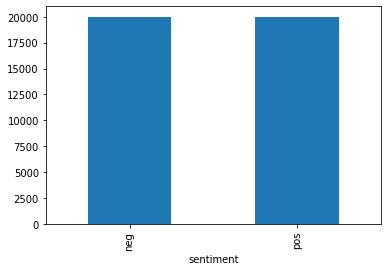

In [ ]:
'''
we plotted a bar graph showing the distribution of the labels in the dataset. 
We find that both positive and negative labels are equally distributed with 20000 samples in each label.
'''
df.groupby('sentiment').category_id.count().plot.bar(ylim=0)

In [ ]:
tfidf, features, labels = preprocessing(df)

In [ ]:
np.random.seed(0)
# Randomly select 3 % of samples
index = np.random.choice(range(len(features)), size=int(len(features)*0.03), replace=False)          
# Array of all projected features of 30% of Randomly chosen samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[index])  

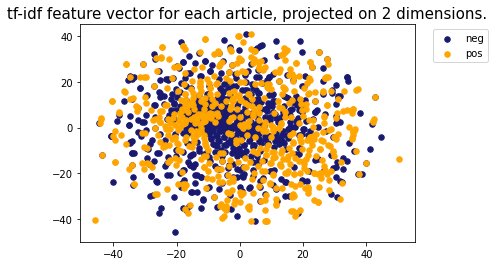

In [ ]:
colors = ['midnightblue', 'orange']
# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[index] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",fontdict=dict(fontsize=15))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [ ]:
'''
Here we split the dataset into train and test (30% test) using sklearn library
'''
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
## These functions will evaluate the model (by first training the model and then testing it)

def print_estimator_name(estimator):
    print(estimator.__class__.__name__)

def evaluate(model, X_train, X_test, y_train, y_test):
    print_estimator_name(model)
    #Train Algorithm
    model.fit(X_train, y_train)
    # Make Predictions
    y_pred = model.predict(X_test)
    print('Accuracy of the model is:', round(accuracy_score(y_pred,y_test),4))

In [ ]:
models = [MultinomialNB(), LinearSVC(random_state=42 ,tol=1e-06), RandomForestClassifier(max_depth=2, random_state=42), LogisticRegression(random_state=42)]

In [ ]:
for model in models:
    evaluate(model,X_train, X_test, y_train, y_test)
    print()

MultinomialNB
Accuracy of the model is: 0.8488

LinearSVC
Accuracy of the model is: 0.8699

RandomForestClassifier
Accuracy of the model is: 0.7898

LogisticRegression
Accuracy of the model is: 0.8814



In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train,y_train)
# Make Predictions
y_pred = model.predict(X_test)
print('Accuracy of the model is:', round(accuracy_score(y_pred,y_test),4))

Accuracy of the model is: 0.8814


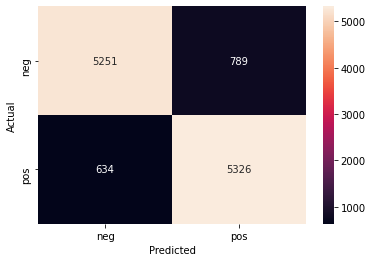


Classification Report

              precision    recall  f1-score   support

         neg       0.89      0.87      0.88      6040
         pos       0.87      0.89      0.88      5960

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



In [ ]:
# Printing the confusion matrix
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sn.heatmap(cm, annot=True, fmt='d', xticklabels=category_id_df.sentiment.values, yticklabels=category_id_df.sentiment.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
## Print the classification report
target_names = df['sentiment'].unique()
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
import pickle

# save model and other necessary modules
all_info_want_to_save = {
    'model': model,
    'vectorizer': TfidfVectorizer(max_features=2500,vocabulary=tfidf.vocabulary_)
}

with open("trained_model.pickle","wb") as save_path:
    pickle.dump(all_info_want_to_save, save_path)